<a href="https://colab.research.google.com/github/GabrielleYa/Prediction-of-Product-Sales/blob/main/Copy_of_Project_1_Feature_Imoportance_(Core)wk5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Project 1 - Part 5 (Core) <center>

- **Author:** Gabrielle Ray

## **Assignment Overview**

We will continue to work on your sales prediction project. The goal of this step is to help the retailer by using machine learning to make predictions about future sales based on the data provided.

For Part 5, you will go back to your original, uncleaned, sales prediction dataset with the goal of preventing data leakage.

You should load a fresh version of the original data set here using pd.read_csv() and start your cleaning process over to ensure there is no data leakage!

- Before splitting your data, you can drop duplicates and fix inconsistencies in categorical data.* (*There is a way to do this after the split, but for this project, you may perform this step before the split)

- Identify the features (X) and target (y): Assign the "Item_Outlet_Sales" column as your target and the rest of the relevant variables as your features matrix.
- Hint: We recommend you drop the "Item_Identifier" feature because it has very high cardinality.
- Perform a train test split
- Create a preprocessing object to prepare the dataset for Machine Learning
- Make sure your imputation of missing values occurs after the train test split using SimpleImputer.
- Commit your work to GitHub.

Submit a link to your GitHub repo to complete this assignment. Do not upload a notebook for this assignment, or your submission will not be accepted.

## **Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Imports**

In [2]:
# Needed Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
# Warnings
import warnings

# Model validation Train Test Split
from sklearn.model_selection import train_test_split

# Preprcessing

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

import joblib

# setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

# Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

# Sklearn display
from sklearn import set_config


## **Functions**

### **Regression Metrics**

In [3]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics


### **Evaluate Regression**

In [4]:
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

# **Notebook Defualts and Runtime Configurations**

## **Warnings**

In [5]:
# Setting filter warings to ignore
warnings.filterwarnings('ignore')

## **Pandas Display Configurations**

In [6]:
# Displaying all columns
pd.set_option('display.max_column', 50)

# Displaying all rows
pd.set_option('display.max_rows', 50)

## **Sklearn Display Configurations**

In [7]:
# Sklearn Display
set_config(display ='diagram')
set_config(transform_output='pandas')

## **Load Data**

In [8]:
# Loading in file with pandas
fpath = "/content/drive/MyDrive/CodingDojo/02-MachineLearning/Week05/Data/sales_predictions_2023.csv"
df_sales = pd.read_csv(fpath)
df_sales.info()
df_sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## **Clean Data**

### .dtypes

In [9]:
# Loading the data type for each variable
df_sales.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

### Duplicates

In [10]:
# Dropping any duplicate rows in the data set if there are any
duplicated_rows = df_sales.duplicated()
duplicated_rows

0       False
1       False
2       False
3       False
4       False
        ...  
8518    False
8519    False
8520    False
8521    False
8522    False
Length: 8523, dtype: bool

In [11]:
# Getting the sum of duplicates
df_sales.duplicated().sum()

0

### Inconsistent Values

In [12]:
# Define a variable and show inconsistent categories
string_cols = df_sales.select_dtypes("object").columns

In [13]:
# Confirm the varieble and review object columns
string_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [14]:
# Creating a for loop to print the output for every string column
for cols in string_cols:
  print(f'Value Counts for {cols}')
  print(df_sales[cols].value_counts())

Value Counts for Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64
Value Counts for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
Value Counts for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
Value Counts for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035

- Item_Fat_Content has inconsistent values

In [15]:
# Viewing the Item_Fat_Content value counts
df_sales['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [16]:
# Creating a data dictionary to replace the inconsistent values in our Item_Fat_Content column
df_sales['Item_Fat_Content'] = df_sales['Item_Fat_Content'].replace({'LF':"Low Fat", 'low fat': "Low Fat", 'reg':"Regular"})

In [17]:
# Viewing results
df_sales['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [18]:
# Creating a data dictionary to replace inconistent values in our Outlet Sales column
df_sales['Outlet_Size'] = df_sales['Outlet_Size'].replace({'High':"Large"})

In [19]:
# Viewing resutls
df_sales['Outlet_Size'].value_counts()

Medium    2793
Small     2388
Large      932
Name: Outlet_Size, dtype: int64

In [20]:
# Confirming value inconsistency correction
for cols in string_cols:
  print(f'Value Counts for {cols}')
  print(df_sales[cols].value_counts())
  print("")

Value Counts for Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

Value Counts for Item_Fat_Content
Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

Value Counts for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Value Counts for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017   

In [21]:
# Present the statistical summary of each of the numerical columns
df_sales.describe().round()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.0,8523.0,8523.0,8523.0,8523.0
mean,13.0,0.0,141.0,1998.0,2181.0
std,5.0,0.0,62.0,8.0,1706.0
min,5.0,0.0,31.0,1985.0,33.0
25%,9.0,0.0,94.0,1987.0,834.0
50%,13.0,0.0,143.0,1999.0,1794.0
75%,17.0,0.0,186.0,2004.0,3101.0
max,21.0,0.0,267.0,2009.0,13087.0


In [22]:
# Removinf the item
drop_column = df_sales.drop(columns= "Item_Identifier")

## **.drop()**

- Item_Ientifier has too many entries and does not help our prediction, so the column will be dropped.

In [23]:
# Removinf the item
df_sales= df_sales.drop('Item_Identifier', axis=1)

## **Train, Test, and Split**

In [24]:
# Defining features (X) and target (y)
target = "Item_Outlet_Sales"
X = df_sales.drop(columns = [target]).copy()
y = df_sales[target].copy()

In [25]:
# Trai, test, split and viewing the first 5 rows of the X_train
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,Low Fat,0.029565,Household,256.4646,OUT018,2009,Medium,Tier 3,Supermarket Type2
7510,15.250,Regular,0.000000,Snack Foods,179.7660,OUT018,2009,Medium,Tier 3,Supermarket Type2
5828,12.350,Regular,0.158716,Meat,157.2946,OUT049,1999,Medium,Tier 1,Supermarket Type1
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,OUT035,2004,Small,Tier 2,Supermarket Type1
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,OUT045,2002,NaN,Tier 2,Supermarket Type1


In [26]:
# Checking the sum of missing vaules in X_train
X_train.isna().sum()

Item_Weight                  1107
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1812
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [27]:
# Checking the dtypes of X_train
X_train.dtypes

Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
dtype: object

## **Defining Groups of features using List**

### **Numeric Features**

In [28]:
# save list of numeric features
num_cols = X_train.select_dtypes('number').columns
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')

### **Ordinal Features**

In [29]:
# Save list
ord_cols = ['Outlet_Size']

### **Categorical Features**

In [30]:
# Save list of nominal features
cat_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns
cat_cols

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

## **Impute the Numeric Columns**

In [31]:
# Instantiate and fit the imputer for numeric features
impute_median = SimpleImputer(strategy='median')
impute_median.fit(X_train[num_cols])

SimpleImputer(strategy='median')

In [32]:
# Transforming the traning and test numeric features and save as new vars
X_train_num_imputed = impute_median.transform(X_train[num_cols])
X_test_num_imputed = impute_median.transform(X_test[num_cols])

In [33]:
# Confirming there are no more null values
X_train_num_imputed.isna().sum()

Item_Weight                  0
Item_Visibility              0
Item_MRP                     0
Outlet_Establishment_Year    0
dtype: int64

## **Impute Categorical Columns**

In [34]:
# Instantiate and fit the imputer for categorical features
impute_missing = SimpleImputer(strategy='constant', fill_value='MISSING')
impute_missing.fit(X_train[cat_cols])

SimpleImputer(fill_value='MISSING', strategy='constant')

In [35]:
# Transform the training and test features and save as new vars
X_train_cat_imputed = impute_missing.transform(X_train[cat_cols])
X_test_cat_imputed = impute_missing.transform(X_test[cat_cols])

In [36]:
# Confriming there are no null values remaining
X_test_cat_imputed.isna().sum()

Item_Fat_Content        0
Item_Type               0
Outlet_Identifier       0
Outlet_Location_Type    0
Outlet_Type             0
dtype: int64

## **Impute Ordinal Columns**

In [37]:
# Instantaite and fit the imputer for ordinal features
impute_most_freq = SimpleImputer(strategy='most_frequent')
impute_most_freq.fit(X_train[ord_cols])

SimpleImputer(strategy='most_frequent')

In [38]:
# Transform the train and test categorical features and save as new vars
X_train_ord_imputed = impute_most_freq.transform(X_train[ord_cols])
X_test_ord_imputed = impute_most_freq.transform(X_test[ord_cols])

## **Create Pipelines and Define Tuples**

### **Numeric Pipeline**

In [39]:
# PREPROCESSING PIPELINE FOR NUMERIC DATA
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
num_pipe

Numeric Columns: Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

### **Define Numeric Tuple for ColumnTransformer**

In [40]:
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
        'Outlet_Establishment_Year'],
       dtype='object'))

### **Categorical Pipeline**

In [41]:
# PREPROCESSING PIPELINE FOR ONE-HOT-ENCODED DATA
# Save list of column names
ohe_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "NA")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_pipe

OneHotEncoder Columns: Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='NA', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

### **Define Categorical Tuple for ColumnTransformer**

In [42]:
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
ohe_tuple

('categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='NA', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
        'Outlet_Location_Type', 'Outlet_Type'],
       dtype='object'))

### **Ordinal Pipeline**

In [43]:
# PREPROCESSING PIPELINE FOR ORDINAL DATA
# Save list of column names
ord_cols = ['Outlet_Size']
print("Ordinal Columns:", ord_cols)
# Create imputer for ordinal data
impute_na_ord = SimpleImputer(strategy='most_frequent')
## Making the OrdinalEncoder
# Specifying order of categories for our  Ordinal Qual/Cond Columms
qual_cond_order = ['Small', 'Medium', 'Large']
# Making the list of order lists for OrdinalEncoder
ordinal_category_orders = [qual_cond_order]
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
# Making a final scaler to scale category #'s
scaler_ord = StandardScaler()
## Making an ord_pipe
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)
ord_pipe

Ordinal Columns: ['Outlet_Size']


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Small', 'Medium', 'Large']])),
                ('standardscaler', StandardScaler())])

### **Define Ordinal Tuple for ColumnTransformer**

In [44]:
# Making an ordinal_tuple for ColumnTransformer
ord_tuple = ('ordinal', ord_pipe, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Small', 'Medium', 'Large']])),
                 ('standardscaler', StandardScaler())]),
 ['Outlet_Size'])

## Features:

- Ordinal: Outlet_Size
- Categorical: Outlet_Establishment, Item_ Weight, Item_Visability, Item_MRP.
- The remaining features are Categorical (Nominal).

## **Instantiate the ColumnTransformer**

In [45]:
# Instantiate with verbose_feature_names_out=False
col_transformer = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple],
                                    verbose_feature_names_out= False)
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  Ord...
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

## **Fit the Transformer on Training Data Only**

In [46]:
# Fitting on the training data
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  Ord...
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

## **Transform Training and Test data**

In [47]:
# Transform the training data
X_train_processed = col_transformer.transform(X_train)

# Transform the testing data
X_test_processed = col_transformer.transform(X_test)

# Veiwing the processed training data
X_train_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,0.827485,-0.712775,1.828109,1.327849,0.287374,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7510,0.566644,-1.291052,0.603369,1.327849,0.287374,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5828,-0.121028,1.813319,0.244541,0.136187,0.287374,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5327,-1.158464,-1.004931,-0.952591,0.732018,-1.384048,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4810,1.538870,-0.965484,-0.336460,0.493686,0.287374,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [48]:
# Displaying the first 5 rows of the X_test
X_test.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
7503,14.300,Low Fat,0.026300,Frozen Foods,79.4302,OUT013,1987,Large,Tier 3,Supermarket Type1
2957,7.930,Low Fat,0.071136,Health and Hygiene,42.7086,OUT046,1997,Small,Tier 1,Supermarket Type1
7031,14.500,Regular,0.041313,Canned,42.0454,OUT049,1999,Medium,Tier 1,Supermarket Type1
1084,NaN,Regular,0.044767,Soft Drinks,173.7054,OUT027,1985,Medium,Tier 3,Supermarket Type3
856,10.195,Regular,0.012456,Meat,197.5110,OUT035,2004,Small,Tier 2,Supermarket Type1


# <center> Project 1 part 6 <center>

## **Assignment Instructions**

CRISP-DM Phase 4 - Modeling

1. Your first task is to build a linear regression model to predict sales.

 - Build a linear regression model.
 - Use the custom evaluation function to get the metrics for your model (on training and test data).

 - Compare the training vs. test R-squared values and answer the question: to what extent is this model overfit/underfit?
2. Your second task is to build a Random Forest model to predict sales.

 - Build a default Random Forest model.

 - Use the custom evaluation function to get the metrics for your model (on training and test data).
 - Compare the training vs. test R-squared values and answer the question: to what extent is this model overfit/underfit?
 - Compare this model's performance to the linear regression model: which model has the best test scores?
3. Use GridSearchCV to tune at least two hyperparameters for a Random Forest model.

- After determining the best parameters from your GridSearch, fit and evaluate a final best model on the entire training set (no folds).

- Compare your tuned model to your default Random Forest: did the performance improve?
CRISP-DM Phase 5 - Evaluation

4. You now have tried several different models on your data set. You need to determine which model to implement.

 - Overall, which model do you recommend?
 - Justify your recommendation.

- In a Markdown cell:
   
   - Interpret your model's performance based on R-squared in a way that your non-technical stakeholder can understand.
 - Select another regression metric (RMSE/MAE/MSE) to express the performance of your model to your stakeholder.

 - Include why you selected this metric to explain to your stakeholder.
 - Compare the training vs. test scores and answer the question: to what extent is this model overfit/underfit?

# **Linear Regression**

###### 1. Your first task is to build a linear regression model to predict sales.

 - Build a linear regression model.


### **Instantiate the model-Linear Regression**

In [49]:
lin_reg = LinearRegression()
lin_reg

LinearRegression()

## **Train the model**

In [50]:
# Fitting the model on the training data
lin_reg.fit(X_train_processed, y_train)

LinearRegression()

## **Predictions**

In [51]:
# Get predictions for the training data
y_predictions_train = lin_reg.predict(X_train_processed)
# Get predictions for the testing data
y_predictions_test = lin_reg.predict(X_test_processed)

#####- Use the custom evaluation function to get the metrics for your model (on training and test data).


## **Evaluate the Results**

In [52]:
# Evaluate model
evaluate_regression(lin_reg, X_train_processed,
                    y_train, X_test_processed, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.131
- MSE = 1,297,556.865
- RMSE = 1,139.104
- R^2 = 0.562

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.089
- MSE = 1,194,326.602
- RMSE = 1,092.853
- R^2 = 0.567


######- Compare the training vs. test R-squared values and answer the question: to what extent is this model overfit/underfit?

There is a 0.005 difference betweent the traing and test data. It is neither overfit or underfit.

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- R^2 = 0.562

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- R^2 = 0.567

# **Random Forest Regresssor**

##### 2. Your second task is to build a Random Forest model to predict sales.

 - Build a default Random Forest model.

## **Instantiate the model-Random Forest**

In [53]:
# Instantiate default random forest model
rf = RandomForestRegressor(random_state = 42)

# Model Pipeline
rf_pipe = make_pipeline(col_transformer, rf)

### **Fit the Pipeline**

In [54]:
# Fitting the model pipeline on the training data only
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='m...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

###### - Use the custom evaluation function to get the metrics for your model (on training and test data).

## **Evaluate**

In [55]:
# Evaluate
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 296.124
- MSE = 182,241.944
- RMSE = 426.898
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 765.671
- MSE = 1,213,934.180
- RMSE = 1,101.787
- R^2 = 0.560


##### - Compare the training vs. test R-squared values and answer the question: to what extent is this model overfit/underfit?

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- R^2 = 0.560

##### - Compare this model's performance to the linear regression model: which model has the best test scores?

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- R^2 = 0.560


------------------------------------------------------------
`Regression Metrics: Training Data`
------------------------------------------------------------
- R^2 = 0.562

------------------------------------------------------------
`Regression Metrics: Test Data`
------------------------------------------------------------
- R^2 = 0.567

- The Random Forest Regressor Model performed terribly. The model is overfit.

- The Linear Regression Model performed a lot better and is the best between the two. The model has both a low variance and low bias

## **Tune with GridSearchCV**

##### 3. Use GridSearchCV to tune at least two hyperparameters for a Random Forest model.


In [56]:
# Parameters for tuning
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
          'Outlet_Establishment_Year'],
         dtype='object')),
                                   ('ordinal',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ordinalencoder',
                                                     Ord...
                                                     StandardScaler())]),
                           

## **Define Param Grid**

In [57]:
# Define param grid with options to try
# define param grid with options to try
params = {'randomforestregressor__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10
                                               , None],
          'randomforestregressor__n_estimators': [100, 150, 200, 250],
          'randomforestregressor__min_samples_split':  [2, 3, 4],
          'randomforestregressor__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8]}

## **Instantiate and Fit GridSearch**

##### - After determining the best parameters from your GridSearch, fit and evaluate a final best model on the entire training set (no folds).


In [58]:
# Instantiate the gridsearch
gridsearch = GridSearchCV(rf_pipe, params, n_jobs=-1, cv= 3, verbose=1)
# Fit the gridsearch on training data
gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 1056 candidates, totalling 3168 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('simpleimpute...
                                                          verbose_feature_names_out=False)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10,
                                                              None],
                         'randomforestregressor__min_samples_leaf': [1, 2, 3, 4,
                                                                     5, 6, 7,
                                                                     8],
                         'randomforestregressor__min_samples_split': [2, 3, 4],
                         'randomforestregressor__n_estimators': [100, 150, 200,
                                                                 250]},
             verbose=1)

## **Define, Refit, and Evaluate the Best Model**

In [59]:
# Define and refit best model
best_rf = gridsearch.best_estimator_
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 742.171
- MSE = 1,111,169.988
- RMSE = 1,054.120
- R^2 = 0.625

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 727.466
- MSE = 1,100,022.892
- RMSE = 1,048.820
- R^2 = 0.601


##### - Compare your tuned model to your default Random Forest: did the performance improve?
CRISP-DM Phase 5 - Evaluation

**`Default Model`**
------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- R^2 = 0.560


`Tuned Model`
------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- R^2 = 0.625

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- R^2 = 0.601

- The default model metric's were overfit.
- The tuned model metric's come out balanced in both bias and variance.
- The `Random Tree Forest` model, would be the model to present to the stakeholder.

## **Models Evaluated & Results**


------------------------------------------------------------
Linear Regression Metrics: Test Data

- MAE = 804.089
- MSE = 1,194,326.602
- RMSE = 1,092.853
- R^2 = 0.567

------------------------------------------------------------
Random Forest Regressor Metrics: Test Data

- MAE = 727.466
- MSE = 1,100,022.892
- RMSE = 1,048.820
- R^2 = 0.601

- The Final Model Chosen was a Random Forest Regressor Model with the highest R2 score (compared to the Linear Regression Model) of 0.601

- For the testing set on the model, 60% of the model's features are being used to explain the varience of the target.

- The Mean Absolute Error was off by about $727.466

- The Mean Squared Error was $1,111,169.988.

- The Root Mean Squared Error had a calculation of $1,048.820

### **Extracting and Visualizing Coefficients**

### **Extracting Coefficients from lin_reg**

In [60]:
# Displaying the model's coefficients
lin_reg.coef_

array([-7.51253475e+00, -2.15033052e+01,  9.84667131e+02,  1.14142776e+15,
        3.35291886e+14, -2.69659713e+13, -2.69659713e+13, -1.26946383e+14,
       -1.26946383e+14, -1.26946383e+14, -1.26946383e+14, -1.26946383e+14,
       -1.26946383e+14, -1.26946383e+14, -1.26946383e+14, -1.26946383e+14,
       -1.26946383e+14, -1.26946383e+14, -1.26946383e+14, -1.26946383e+14,
       -1.26946383e+14, -1.26946383e+14, -1.26946383e+14, -1.64056779e+15,
        1.14494511e+15, -8.26179640e+14, -1.24575079e+15,  1.70496872e+14,
       -4.21831637e+14,  1.42293312e+14, -1.46081772e+14,  3.87973808e+14,
       -4.44479570e+14,  3.38781414e+14, -3.67675105e+14, -1.78822609e+14,
       -9.20092530e+14, -2.76980435e+15, -2.81112484e+15, -3.70574229e+14])

In [61]:
# Display the model's intercept
lin_reg.intercept_

2777612884495506.0

In [62]:
# Saving the coefficients
coef_series = pd.Series(lin_reg.coef_, index=lin_reg.feature_names_in_)
coef_series

Item_Weight                       -7.512535e+00
Item_Visibility                   -2.150331e+01
Item_MRP                           9.846671e+02
Outlet_Establishment_Year          1.141428e+15
Outlet_Size                        3.352919e+14
Item_Fat_Content_Low Fat          -2.696597e+13
Item_Fat_Content_Regular          -2.696597e+13
Item_Type_Baking Goods            -1.269464e+14
Item_Type_Breads                  -1.269464e+14
Item_Type_Breakfast               -1.269464e+14
Item_Type_Canned                  -1.269464e+14
Item_Type_Dairy                   -1.269464e+14
Item_Type_Frozen Foods            -1.269464e+14
Item_Type_Fruits and Vegetables   -1.269464e+14
Item_Type_Hard Drinks             -1.269464e+14
Item_Type_Health and Hygiene      -1.269464e+14
Item_Type_Household               -1.269464e+14
Item_Type_Meat                    -1.269464e+14
Item_Type_Others                  -1.269464e+14
Item_Type_Seafood                 -1.269464e+14
Item_Type_Snack Foods             -1.269

In [63]:
# formatting numbers to not use a , and to use thousands sep, and 4 digits floats
pd.set_option('display.float_format', lambda x: f"{x:,.4f}")

In [64]:
# show coefs again
coef_series

Item_Weight                                           -7.5125
Item_Visibility                                      -21.5033
Item_MRP                                             984.6671
Outlet_Establishment_Year          1,141,427,762,199,909.7500
Outlet_Size                          335,291,885,619,900.5625
Item_Fat_Content_Low Fat             -26,965,971,277,073.2891
Item_Fat_Content_Regular             -26,965,971,277,010.3711
Item_Type_Baking Goods              -126,946,383,182,939.7656
Item_Type_Breads                    -126,946,383,182,968.0156
Item_Type_Breakfast                 -126,946,383,182,895.1250
Item_Type_Canned                    -126,946,383,182,912.3281
Item_Type_Dairy                     -126,946,383,183,046.6406
Item_Type_Frozen Foods              -126,946,383,182,940.5625
Item_Type_Fruits and Vegetables     -126,946,383,182,893.2969
Item_Type_Hard Drinks               -126,946,383,182,924.7031
Item_Type_Health and Hygiene        -126,946,383,182,911.7500
Item_Typ

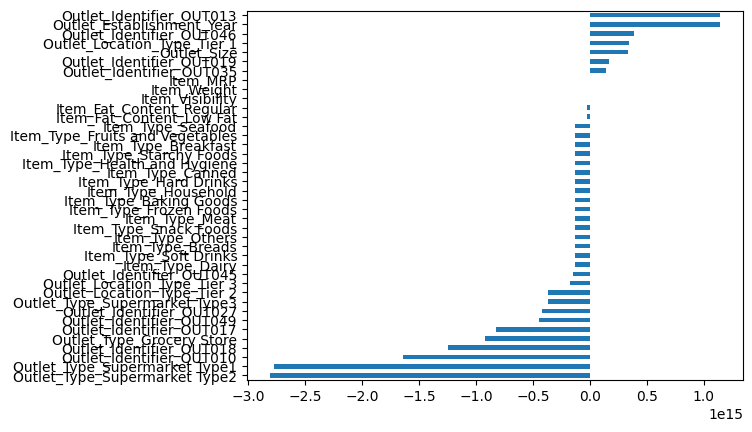

In [65]:
# Create a barplot of the coefficients
# sorted by values
coef_series.sort_values().plot(kind='barh');

- Most of the features have a negtive correlation with the target.

- The following features present an equal imprtance:
 - Outlet Identifier
 - Outlet Establishment Year

## **Random Forest Model**

In [67]:
# Extract Feature Importances
importances = rf.feature_importances_
importances

array([5.27971338e-02, 9.88291685e-02, 4.41567800e-01, 2.55266171e-02,
       6.25147259e-03, 5.13851465e-03, 4.80589093e-03, 3.98950374e-03,
       2.59344715e-03, 2.60980462e-03, 4.25897647e-03, 6.38191097e-03,
       5.52213092e-03, 8.01285072e-03, 3.00121107e-03, 4.20567306e-03,
       6.62189122e-03, 3.61914597e-03, 1.62626295e-03, 1.68358691e-03,
       8.26880048e-03, 5.37786959e-03, 3.38471421e-03, 1.13185004e-05,
       1.72325103e-03, 4.09890128e-03, 1.19407956e-03, 1.41351906e-05,
       3.30453260e-02, 4.28448113e-03, 4.88826910e-03, 3.60193374e-03,
       4.20479757e-03, 3.37010175e-03, 3.41597124e-03, 2.63558589e-03,
       1.91729822e-01, 1.84018927e-03, 1.25474557e-03, 3.26127140e-02])

In [68]:
# Define a function to extract importances from a model
def get_feature_importances(model):
    importances = model.feature_importances_
    feature_names = model.feature_names_in_
    return pd.Series(importances, index=feature_names)

In [69]:
# Define a series variable by
# calling the get_feature_importances function
# to obtain importances from a model
importances =  get_feature_importances(rf)
importances

Item_Weight                       0.0528
Item_Visibility                   0.0988
Item_MRP                          0.4416
Outlet_Establishment_Year         0.0255
Outlet_Size                       0.0063
Item_Fat_Content_Low Fat          0.0051
Item_Fat_Content_Regular          0.0048
Item_Type_Baking Goods            0.0040
Item_Type_Breads                  0.0026
Item_Type_Breakfast               0.0026
Item_Type_Canned                  0.0043
Item_Type_Dairy                   0.0064
Item_Type_Frozen Foods            0.0055
Item_Type_Fruits and Vegetables   0.0080
Item_Type_Hard Drinks             0.0030
Item_Type_Health and Hygiene      0.0042
Item_Type_Household               0.0066
Item_Type_Meat                    0.0036
Item_Type_Others                  0.0016
Item_Type_Seafood                 0.0017
Item_Type_Snack Foods             0.0083
Item_Type_Soft Drinks             0.0054
Item_Type_Starchy Foods           0.0034
Outlet_Identifier_OUT010          0.0000
Outlet_Identifie

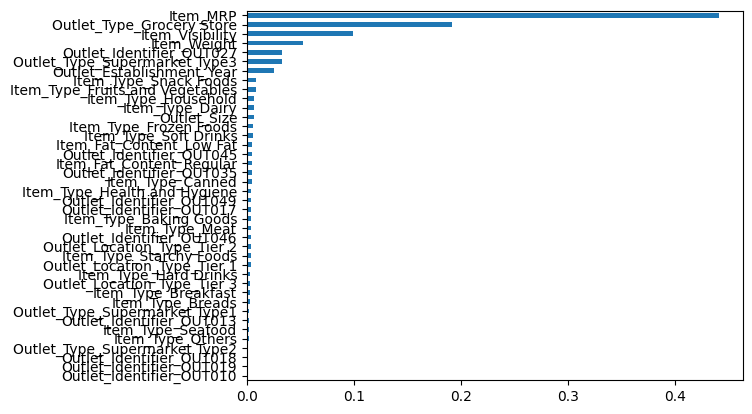

In [70]:
# Create a barplot of the importance series variable
# sorted by values
importances.sort_values().plot(kind='barh');

- Item MRP, Outlet Type Grocery Store, Item Visibilty, Item Weight, and Outlet Identifier all present high feature importance.

- *Note: since Item MRP takes up most of the feature importance, lets try dropping it to see if other features present a higher importance.*